In [31]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import lightning as L

In [2]:
# torch.version.cuda
# print(torch.version.cuda)
# L.seed_everything(42)

Global seed set to 42


42

### Feature extraction

In [32]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [33]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


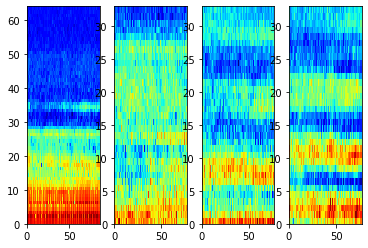

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

### CNN-model

In [129]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        self.layer1_filt = 64
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
        lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1,1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1,1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1,1))

        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(self.layer1_filt*(1+(frames_in_segment-lf_width)//lf_w_stride) + # *(1+(self.lf_num-lf_height)//lf_height)
                            self.layer1_filt*(1+(frames_in_segment-mf_width)//mf_w_stride) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            self.layer1_filt*(1+(frames_in_segment-hf_width)//hf_w_stride) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        # print(x.shape)
        # print(x1.shape)
        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())
        # print(x2.shape)
        # print(x3.shape)
        
        out1 = self.conv_lf(out1)
        out2 = self.conv_mf(out2)
        out3 = self.conv_hf(out3)
                
        # print(out2.shape)
        # print(out3.shape)

        out1 = torch.relu(out1)
        out2 = torch.relu(out2)
        out3 = torch.relu(out3)
        
        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out    

#### training_loop

In [73]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        best_acc = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        val_score = list()
        loss_val = 0.0
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)
                pred = torch.squeeze(pred,1)                
                loss = loss_fn(pred, label)
                loss_val += loss.item()
                val_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)                        
                else:
                    pred = torch.tensor(0, dtype=torch.float64)
                if pred==label:
                    TP_TN_sum +=1
        acc_val = TP_TN_sum/len(val_score)    
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)

        if acc_val>=best_acc:
            torch.save(model.state_dict(), MODEL_PATH)            
            # torch.save(model, MODEL_PATH)

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(12,4))
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    plt.subplot(1,2,2)
    plt.plot(range(len(lrs)),lrs)
    plt.xlabel('step')
    plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

### Single NN training & evaluation

In [48]:
# Test inference
model = ALS_CNN()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add chanel dimension
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [76]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    PATH = 'model_backup\cnn_init.pt'
    PATH_optim = 'model_backup\cnn_optim_init.pt'
    PATH_lr = 'model_backup\cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')
    
    return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

Epoch 1: 100%|██████████| 125/125 [00:12<00:00, 10.21it/s]


2023-05-19 17:08:24.913920 Epoch 1, Train loss 0.506, Val loss 0.472, Acc_val = 0.76


Epoch 2: 100%|██████████| 125/125 [00:12<00:00,  9.98it/s]


2023-05-19 17:08:39.606063 Epoch 2, Train loss 0.357, Val loss 0.451, Acc_val = 0.79


Epoch 3: 100%|██████████| 125/125 [00:11<00:00, 11.22it/s]


2023-05-19 17:08:52.814340 Epoch 3, Train loss 0.324, Val loss 1.044, Acc_val = 0.47


Epoch 4: 100%|██████████| 125/125 [00:11<00:00, 11.06it/s]


2023-05-19 17:09:06.178303 Epoch 4, Train loss 0.308, Val loss 0.452, Acc_val = 0.79


Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 11.40it/s]


2023-05-19 17:09:19.103167 Epoch 5, Train loss 0.293, Val loss 0.453, Acc_val = 0.80


Epoch 6: 100%|██████████| 125/125 [00:11<00:00, 11.30it/s]


2023-05-19 17:09:32.298195 Epoch 6, Train loss 0.293, Val loss 0.753, Acc_val = 0.54


Epoch 7: 100%|██████████| 125/125 [00:10<00:00, 11.51it/s]


2023-05-19 17:09:45.216459 Epoch 7, Train loss 0.289, Val loss 0.436, Acc_val = 0.84


Epoch 8: 100%|██████████| 125/125 [00:11<00:00, 10.74it/s]


2023-05-19 17:09:59.573204 Epoch 8, Train loss 0.271, Val loss 0.434, Acc_val = 0.70


Epoch 9: 100%|██████████| 125/125 [00:11<00:00, 10.45it/s]


2023-05-19 17:10:14.261230 Epoch 9, Train loss 0.285, Val loss 0.489, Acc_val = 0.83


Epoch 10: 100%|██████████| 125/125 [00:12<00:00, 10.26it/s]


2023-05-19 17:10:29.066082 Epoch 10, Train loss 0.276, Val loss 0.474, Acc_val = 0.83


Epoch 11: 100%|██████████| 125/125 [00:12<00:00, 10.29it/s]


2023-05-19 17:10:43.705935 Epoch 11, Train loss 0.269, Val loss 0.423, Acc_val = 0.81


Epoch 12: 100%|██████████| 125/125 [00:11<00:00, 10.56it/s]


2023-05-19 17:10:57.856680 Epoch 12, Train loss 0.260, Val loss 0.490, Acc_val = 0.73


Epoch 13: 100%|██████████| 125/125 [00:11<00:00, 10.49it/s]


2023-05-19 17:11:12.039391 Epoch 13, Train loss 0.270, Val loss 0.362, Acc_val = 0.85


Epoch 14: 100%|██████████| 125/125 [00:11<00:00, 10.89it/s]


2023-05-19 17:11:26.023538 Epoch 14, Train loss 0.273, Val loss 0.549, Acc_val = 0.69


Epoch 15: 100%|██████████| 125/125 [00:12<00:00,  9.81it/s]


2023-05-19 17:11:41.276427 Epoch 15, Train loss 0.261, Val loss 0.492, Acc_val = 0.82


Epoch 16: 100%|██████████| 125/125 [00:11<00:00, 11.15it/s]


2023-05-19 17:11:55.338603 Epoch 16, Train loss 0.256, Val loss 0.428, Acc_val = 0.84


Epoch 17: 100%|██████████| 125/125 [00:12<00:00,  9.71it/s]


2023-05-19 17:12:11.254523 Epoch 17, Train loss 0.268, Val loss 0.526, Acc_val = 0.71


Epoch 18: 100%|██████████| 125/125 [00:12<00:00,  9.73it/s]


2023-05-19 17:12:26.961656 Epoch 18, Train loss 0.269, Val loss 0.393, Acc_val = 0.83


Epoch 19: 100%|██████████| 125/125 [00:13<00:00,  8.94it/s]


2023-05-19 17:12:44.238057 Epoch 19, Train loss 0.267, Val loss 0.608, Acc_val = 0.66


Epoch 20: 100%|██████████| 125/125 [00:13<00:00,  9.44it/s]


2023-05-19 17:13:00.320077 Epoch 20, Train loss 0.256, Val loss 0.493, Acc_val = 0.73


Epoch 21: 100%|██████████| 125/125 [00:13<00:00,  9.30it/s]


2023-05-19 17:13:16.537488 Epoch 21, Train loss 0.249, Val loss 0.473, Acc_val = 0.77


Epoch 22: 100%|██████████| 125/125 [00:15<00:00,  7.83it/s]


2023-05-19 17:13:35.773651 Epoch 22, Train loss 0.250, Val loss 0.484, Acc_val = 0.76


Epoch 23: 100%|██████████| 125/125 [00:16<00:00,  7.63it/s]


2023-05-19 17:13:55.539933 Epoch 23, Train loss 0.257, Val loss 0.480, Acc_val = 0.78


Epoch 24: 100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


2023-05-19 17:14:16.008663 Epoch 24, Train loss 0.246, Val loss 0.437, Acc_val = 0.83


Epoch 25: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


2023-05-19 17:14:36.754845 Epoch 25, Train loss 0.244, Val loss 0.550, Acc_val = 0.70


Epoch 26: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


2023-05-19 17:14:58.072663 Epoch 26, Train loss 0.250, Val loss 0.606, Acc_val = 0.68


Epoch 27: 100%|██████████| 125/125 [00:17<00:00,  7.02it/s]


2023-05-19 17:15:19.644571 Epoch 27, Train loss 0.238, Val loss 0.709, Acc_val = 0.64


Epoch 28: 100%|██████████| 125/125 [00:17<00:00,  7.12it/s]


2023-05-19 17:15:40.465623 Epoch 28, Train loss 0.249, Val loss 0.549, Acc_val = 0.71


Epoch 29: 100%|██████████| 125/125 [00:17<00:00,  7.21it/s]


2023-05-19 17:16:01.457240 Epoch 29, Train loss 0.241, Val loss 0.765, Acc_val = 0.60


Epoch 30: 100%|██████████| 125/125 [00:18<00:00,  6.63it/s]


2023-05-19 17:16:23.837322 Epoch 30, Train loss 0.241, Val loss 0.587, Acc_val = 0.69


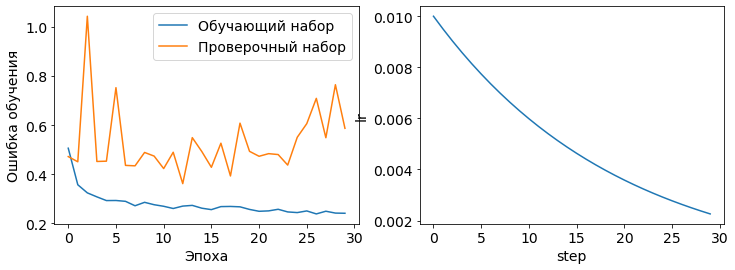

Acc =  0.6191430719118015


Epoch 1: 100%|██████████| 132/132 [00:12<00:00, 10.50it/s]


2023-05-19 17:16:47.495798 Epoch 1, Train loss 0.554, Val loss 1.690, Acc_val = 0.38


Epoch 2: 100%|██████████| 132/132 [00:12<00:00, 10.80it/s]


2023-05-19 17:17:00.787011 Epoch 2, Train loss 0.449, Val loss 0.389, Acc_val = 0.97


Epoch 3: 100%|██████████| 132/132 [00:11<00:00, 11.98it/s]


2023-05-19 17:17:12.946283 Epoch 3, Train loss 0.431, Val loss 1.028, Acc_val = 0.52


Epoch 4: 100%|██████████| 132/132 [00:11<00:00, 11.91it/s]


2023-05-19 17:17:25.101310 Epoch 4, Train loss 0.397, Val loss 0.668, Acc_val = 0.61


Epoch 5: 100%|██████████| 132/132 [00:11<00:00, 11.76it/s]


2023-05-19 17:17:37.418119 Epoch 5, Train loss 0.387, Val loss 0.847, Acc_val = 0.54


Epoch 6: 100%|██████████| 132/132 [00:11<00:00, 11.80it/s]


2023-05-19 17:17:49.646280 Epoch 6, Train loss 0.363, Val loss 0.405, Acc_val = 0.82


Epoch 7: 100%|██████████| 132/132 [00:11<00:00, 11.34it/s]


2023-05-19 17:18:02.324109 Epoch 7, Train loss 0.358, Val loss 0.959, Acc_val = 0.33


Epoch 8: 100%|██████████| 132/132 [00:11<00:00, 11.48it/s]


2023-05-19 17:18:14.876913 Epoch 8, Train loss 0.338, Val loss 0.600, Acc_val = 0.50


Epoch 9: 100%|██████████| 132/132 [00:11<00:00, 11.63it/s]


2023-05-19 17:18:27.446667 Epoch 9, Train loss 0.322, Val loss 0.755, Acc_val = 0.48


Epoch 10: 100%|██████████| 132/132 [00:12<00:00, 10.97it/s]


2023-05-19 17:18:40.569722 Epoch 10, Train loss 0.313, Val loss 0.778, Acc_val = 0.66


Epoch 11: 100%|██████████| 132/132 [00:11<00:00, 11.64it/s]


2023-05-19 17:18:53.382052 Epoch 11, Train loss 0.319, Val loss 0.694, Acc_val = 0.45


Epoch 12: 100%|██████████| 132/132 [00:12<00:00, 10.87it/s]


2023-05-19 17:19:06.805620 Epoch 12, Train loss 0.320, Val loss 2.119, Acc_val = 0.38


Epoch 13: 100%|██████████| 132/132 [00:11<00:00, 11.58it/s]


2023-05-19 17:19:19.412171 Epoch 13, Train loss 0.325, Val loss 1.708, Acc_val = 0.38


Epoch 14: 100%|██████████| 132/132 [00:11<00:00, 11.34it/s]


2023-05-19 17:19:32.411051 Epoch 14, Train loss 0.304, Val loss 2.272, Acc_val = 0.59


Epoch 15: 100%|██████████| 132/132 [00:11<00:00, 11.20it/s]


2023-05-19 17:19:45.263786 Epoch 15, Train loss 0.418, Val loss 1.118, Acc_val = 0.67


Epoch 16: 100%|██████████| 132/132 [00:11<00:00, 11.59it/s]


2023-05-19 17:19:57.851115 Epoch 16, Train loss 0.324, Val loss 1.103, Acc_val = 0.26


Epoch 17: 100%|██████████| 132/132 [00:11<00:00, 11.08it/s]


2023-05-19 17:20:10.987097 Epoch 17, Train loss 0.297, Val loss 0.848, Acc_val = 0.66


Epoch 18: 100%|██████████| 132/132 [00:11<00:00, 11.55it/s]


2023-05-19 17:20:23.497775 Epoch 18, Train loss 0.295, Val loss 1.509, Acc_val = 0.58


Epoch 19: 100%|██████████| 132/132 [00:11<00:00, 11.35it/s]


2023-05-19 17:20:36.234873 Epoch 19, Train loss 0.281, Val loss 0.914, Acc_val = 0.69


Epoch 20: 100%|██████████| 132/132 [00:11<00:00, 11.65it/s]


2023-05-19 17:20:48.964114 Epoch 20, Train loss 0.277, Val loss 1.254, Acc_val = 0.01


Epoch 21: 100%|██████████| 132/132 [00:13<00:00,  9.91it/s]


2023-05-19 17:21:03.641073 Epoch 21, Train loss 0.282, Val loss 1.183, Acc_val = 0.62


Epoch 22: 100%|██████████| 132/132 [00:13<00:00,  9.98it/s]


2023-05-19 17:21:18.342947 Epoch 22, Train loss 0.309, Val loss 1.602, Acc_val = 0.38


Epoch 23: 100%|██████████| 132/132 [00:13<00:00,  9.79it/s]


2023-05-19 17:21:33.189084 Epoch 23, Train loss 0.267, Val loss 1.294, Acc_val = 0.46


Epoch 24: 100%|██████████| 132/132 [00:13<00:00,  9.95it/s]


2023-05-19 17:21:47.860814 Epoch 24, Train loss 0.266, Val loss 1.005, Acc_val = 0.68


Epoch 25: 100%|██████████| 132/132 [00:13<00:00, 10.12it/s]


2023-05-19 17:22:02.284347 Epoch 25, Train loss 0.277, Val loss 1.066, Acc_val = 0.65


Epoch 26: 100%|██████████| 132/132 [00:13<00:00,  9.46it/s]


2023-05-19 17:22:17.770891 Epoch 26, Train loss 0.268, Val loss 1.310, Acc_val = 0.40


Epoch 27: 100%|██████████| 132/132 [00:13<00:00,  9.50it/s]


2023-05-19 17:22:33.027742 Epoch 27, Train loss 0.270, Val loss 1.784, Acc_val = 0.38


Epoch 28: 100%|██████████| 132/132 [00:14<00:00,  9.21it/s]


2023-05-19 17:22:48.708626 Epoch 28, Train loss 0.271, Val loss 0.862, Acc_val = 0.44


Epoch 29: 100%|██████████| 132/132 [00:13<00:00, 10.09it/s]


2023-05-19 17:23:03.225658 Epoch 29, Train loss 0.263, Val loss 1.644, Acc_val = 0.47


Epoch 30: 100%|██████████| 132/132 [00:14<00:00,  9.31it/s]


2023-05-19 17:23:18.793945 Epoch 30, Train loss 0.263, Val loss 0.878, Acc_val = 0.48


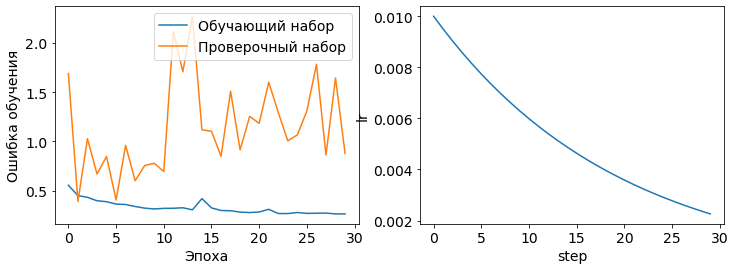

Acc =  0.6922713306546916


Epoch 1: 100%|██████████| 127/127 [00:11<00:00, 11.35it/s]


2023-05-19 17:23:37.281680 Epoch 1, Train loss 0.458, Val loss 0.700, Acc_val = 0.68


Epoch 2: 100%|██████████| 127/127 [00:11<00:00, 11.17it/s]


2023-05-19 17:23:50.058978 Epoch 2, Train loss 0.364, Val loss 0.636, Acc_val = 0.66


Epoch 3: 100%|██████████| 127/127 [00:10<00:00, 11.91it/s]


2023-05-19 17:24:02.108298 Epoch 3, Train loss 0.341, Val loss 0.867, Acc_val = 0.45


Epoch 4: 100%|██████████| 127/127 [00:11<00:00, 10.98it/s]


2023-05-19 17:24:15.281504 Epoch 4, Train loss 0.343, Val loss 0.855, Acc_val = 0.56


Epoch 5: 100%|██████████| 127/127 [00:10<00:00, 11.97it/s]


2023-05-19 17:24:27.333714 Epoch 5, Train loss 0.313, Val loss 0.441, Acc_val = 0.83


Epoch 6: 100%|██████████| 127/127 [00:11<00:00, 11.20it/s]


2023-05-19 17:24:40.028669 Epoch 6, Train loss 0.329, Val loss 0.608, Acc_val = 0.83


Epoch 7: 100%|██████████| 127/127 [00:11<00:00, 11.16it/s]


2023-05-19 17:24:52.811365 Epoch 7, Train loss 0.332, Val loss 0.612, Acc_val = 0.84


Epoch 8: 100%|██████████| 127/127 [00:11<00:00, 11.01it/s]


2023-05-19 17:25:05.836513 Epoch 8, Train loss 0.314, Val loss 0.607, Acc_val = 0.83


Epoch 9: 100%|██████████| 127/127 [00:11<00:00, 10.71it/s]


2023-05-19 17:25:19.057582 Epoch 9, Train loss 0.322, Val loss 0.628, Acc_val = 0.79


Epoch 10: 100%|██████████| 127/127 [00:11<00:00, 11.33it/s]


2023-05-19 17:25:31.718081 Epoch 10, Train loss 0.322, Val loss 0.757, Acc_val = 0.45


Epoch 11: 100%|██████████| 127/127 [00:12<00:00, 10.28it/s]


2023-05-19 17:25:46.042384 Epoch 11, Train loss 0.308, Val loss 0.669, Acc_val = 0.45


Epoch 12: 100%|██████████| 127/127 [00:10<00:00, 11.56it/s]


2023-05-19 17:25:58.563343 Epoch 12, Train loss 0.298, Val loss 0.474, Acc_val = 0.75


Epoch 13: 100%|██████████| 127/127 [00:11<00:00, 11.17it/s]


2023-05-19 17:26:11.451897 Epoch 13, Train loss 0.296, Val loss 0.548, Acc_val = 0.83


Epoch 14: 100%|██████████| 127/127 [00:11<00:00, 10.75it/s]


2023-05-19 17:26:25.376667 Epoch 14, Train loss 0.293, Val loss 0.527, Acc_val = 0.70


Epoch 15: 100%|██████████| 127/127 [00:11<00:00, 10.74it/s]


2023-05-19 17:26:38.900885 Epoch 15, Train loss 0.291, Val loss 0.540, Acc_val = 0.55


Epoch 16: 100%|██████████| 127/127 [00:12<00:00, 10.53it/s]


2023-05-19 17:26:52.740096 Epoch 16, Train loss 0.284, Val loss 0.692, Acc_val = 0.45


Epoch 17: 100%|██████████| 127/127 [00:11<00:00, 10.91it/s]


2023-05-19 17:27:05.992952 Epoch 17, Train loss 0.290, Val loss 0.534, Acc_val = 0.68


Epoch 18: 100%|██████████| 127/127 [00:11<00:00, 11.06it/s]


2023-05-19 17:27:19.608152 Epoch 18, Train loss 0.270, Val loss 0.533, Acc_val = 0.79


Epoch 19: 100%|██████████| 127/127 [00:11<00:00, 11.28it/s]


2023-05-19 17:27:32.418386 Epoch 19, Train loss 0.270, Val loss 0.452, Acc_val = 0.68


Epoch 20: 100%|██████████| 127/127 [00:10<00:00, 11.70it/s]


2023-05-19 17:27:45.156628 Epoch 20, Train loss 0.266, Val loss 0.539, Acc_val = 0.85


Epoch 21: 100%|██████████| 127/127 [00:12<00:00, 10.49it/s]


2023-05-19 17:27:58.868260 Epoch 21, Train loss 0.276, Val loss 0.624, Acc_val = 0.66


Epoch 22: 100%|██████████| 127/127 [00:10<00:00, 12.04it/s]


2023-05-19 17:28:10.815376 Epoch 22, Train loss 0.273, Val loss 0.658, Acc_val = 0.45


Epoch 23: 100%|██████████| 127/127 [00:11<00:00, 10.60it/s]


2023-05-19 17:28:24.209425 Epoch 23, Train loss 0.269, Val loss 0.510, Acc_val = 0.85


Epoch 24: 100%|██████████| 127/127 [00:11<00:00, 10.62it/s]


2023-05-19 17:28:37.986672 Epoch 24, Train loss 0.263, Val loss 0.608, Acc_val = 0.64


Epoch 25: 100%|██████████| 127/127 [00:12<00:00,  9.83it/s]


2023-05-19 17:28:52.904043 Epoch 25, Train loss 0.263, Val loss 0.477, Acc_val = 0.64


Epoch 26: 100%|██████████| 127/127 [00:12<00:00,  9.90it/s]


2023-05-19 17:29:07.499839 Epoch 26, Train loss 0.259, Val loss 0.522, Acc_val = 0.82


Epoch 27: 100%|██████████| 127/127 [00:12<00:00, 10.12it/s]


2023-05-19 17:29:22.276282 Epoch 27, Train loss 0.258, Val loss 0.507, Acc_val = 0.84


Epoch 28: 100%|██████████| 127/127 [00:12<00:00,  9.97it/s]


2023-05-19 17:29:36.767475 Epoch 28, Train loss 0.268, Val loss 0.512, Acc_val = 0.79


Epoch 29: 100%|██████████| 127/127 [00:12<00:00,  9.94it/s]


2023-05-19 17:29:51.548359 Epoch 29, Train loss 0.259, Val loss 0.537, Acc_val = 0.85


Epoch 30: 100%|██████████| 127/127 [00:13<00:00,  9.15it/s]


2023-05-19 17:30:07.325716 Epoch 30, Train loss 0.254, Val loss 0.533, Acc_val = 0.73


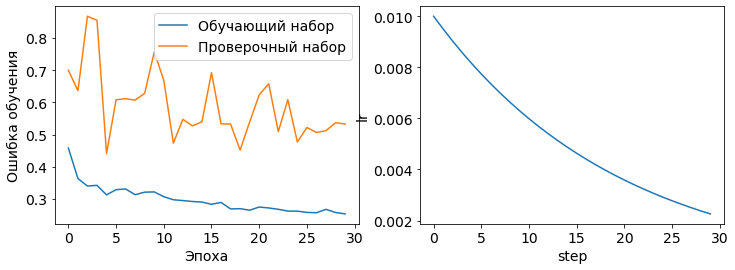

Acc =  0.7196132596685083


Epoch 1: 100%|██████████| 137/137 [00:12<00:00, 11.04it/s]


2023-05-19 17:30:27.383273 Epoch 1, Train loss 0.474, Val loss 0.374, Acc_val = 0.77


Epoch 2: 100%|██████████| 137/137 [00:11<00:00, 11.59it/s]


2023-05-19 17:30:40.438870 Epoch 2, Train loss 0.394, Val loss 0.440, Acc_val = 0.76


Epoch 3: 100%|██████████| 137/137 [00:11<00:00, 11.81it/s]


2023-05-19 17:30:53.677789 Epoch 3, Train loss 0.359, Val loss 0.535, Acc_val = 0.77


Epoch 4: 100%|██████████| 137/137 [00:12<00:00, 11.18it/s]


2023-05-19 17:31:07.613034 Epoch 4, Train loss 0.348, Val loss 0.464, Acc_val = 0.68


Epoch 5: 100%|██████████| 137/137 [00:11<00:00, 11.51it/s]


2023-05-19 17:31:20.702770 Epoch 5, Train loss 0.336, Val loss 0.230, Acc_val = 1.00


Epoch 6: 100%|██████████| 137/137 [00:12<00:00, 11.16it/s]


2023-05-19 17:31:34.147415 Epoch 6, Train loss 0.349, Val loss 0.244, Acc_val = 1.00


Epoch 7: 100%|██████████| 137/137 [00:11<00:00, 11.83it/s]


2023-05-19 17:31:46.888755 Epoch 7, Train loss 0.332, Val loss 0.419, Acc_val = 0.79


Epoch 8: 100%|██████████| 137/137 [00:12<00:00, 11.18it/s]


2023-05-19 17:32:00.331591 Epoch 8, Train loss 0.323, Val loss 0.425, Acc_val = 0.79


Epoch 9: 100%|██████████| 137/137 [00:11<00:00, 11.71it/s]


2023-05-19 17:32:13.365979 Epoch 9, Train loss 0.319, Val loss 0.198, Acc_val = 1.00


Epoch 10: 100%|██████████| 137/137 [00:13<00:00, 10.43it/s]


2023-05-19 17:32:27.806218 Epoch 10, Train loss 0.333, Val loss 0.392, Acc_val = 0.85


Epoch 11: 100%|██████████| 137/137 [00:12<00:00, 11.15it/s]


2023-05-19 17:32:41.214080 Epoch 11, Train loss 0.308, Val loss 0.557, Acc_val = 0.49


Epoch 12: 100%|██████████| 137/137 [00:11<00:00, 12.01it/s]


2023-05-19 17:32:53.708751 Epoch 12, Train loss 0.310, Val loss 0.189, Acc_val = 1.00


Epoch 13: 100%|██████████| 137/137 [00:12<00:00, 10.99it/s]


2023-05-19 17:33:07.290807 Epoch 13, Train loss 0.299, Val loss 0.409, Acc_val = 0.77


Epoch 14: 100%|██████████| 137/137 [00:12<00:00, 11.28it/s]


2023-05-19 17:33:21.043816 Epoch 14, Train loss 0.309, Val loss 0.497, Acc_val = 0.77


Epoch 15: 100%|██████████| 137/137 [00:11<00:00, 11.53it/s]


2023-05-19 17:33:34.100226 Epoch 15, Train loss 0.305, Val loss 0.316, Acc_val = 0.96


Epoch 16: 100%|██████████| 137/137 [00:11<00:00, 11.77it/s]


2023-05-19 17:33:46.946080 Epoch 16, Train loss 0.305, Val loss 0.313, Acc_val = 0.90


Epoch 17: 100%|██████████| 137/137 [00:12<00:00, 10.92it/s]


2023-05-19 17:34:01.002338 Epoch 17, Train loss 0.310, Val loss 0.291, Acc_val = 0.86


Epoch 18: 100%|██████████| 137/137 [00:12<00:00, 11.04it/s]


2023-05-19 17:34:14.744177 Epoch 18, Train loss 0.309, Val loss 0.209, Acc_val = 1.00


Epoch 19: 100%|██████████| 137/137 [00:14<00:00,  9.71it/s]


2023-05-19 17:34:30.433413 Epoch 19, Train loss 0.303, Val loss 0.263, Acc_val = 1.00


Epoch 20: 100%|██████████| 137/137 [00:14<00:00,  9.62it/s]


2023-05-19 17:34:46.184742 Epoch 20, Train loss 0.300, Val loss 0.401, Acc_val = 0.82


Epoch 21: 100%|██████████| 137/137 [00:14<00:00,  9.58it/s]


2023-05-19 17:35:02.300032 Epoch 21, Train loss 0.266, Val loss 0.209, Acc_val = 0.98


Epoch 22: 100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


2023-05-19 17:35:19.857810 Epoch 22, Train loss 0.265, Val loss 0.226, Acc_val = 1.00


Epoch 23: 100%|██████████| 137/137 [00:18<00:00,  7.54it/s]


2023-05-19 17:35:39.769700 Epoch 23, Train loss 0.267, Val loss 0.338, Acc_val = 0.99


Epoch 24: 100%|██████████| 137/137 [00:16<00:00,  8.12it/s]


2023-05-19 17:35:58.518327 Epoch 24, Train loss 0.260, Val loss 0.237, Acc_val = 0.97


Epoch 25: 100%|██████████| 137/137 [00:16<00:00,  8.50it/s]


2023-05-19 17:36:16.224033 Epoch 25, Train loss 0.248, Val loss 0.245, Acc_val = 0.96


Epoch 26: 100%|██████████| 137/137 [00:15<00:00,  8.63it/s]


2023-05-19 17:36:33.706356 Epoch 26, Train loss 0.245, Val loss 0.251, Acc_val = 0.98


Epoch 27: 100%|██████████| 137/137 [00:16<00:00,  8.50it/s]


2023-05-19 17:36:51.393682 Epoch 27, Train loss 0.256, Val loss 0.236, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:16<00:00,  8.40it/s]


2023-05-19 17:37:09.387276 Epoch 28, Train loss 0.242, Val loss 0.255, Acc_val = 0.83


Epoch 29: 100%|██████████| 137/137 [00:17<00:00,  7.76it/s]


2023-05-19 17:37:28.819719 Epoch 29, Train loss 0.248, Val loss 0.174, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:18<00:00,  7.52it/s]


2023-05-19 17:37:49.186387 Epoch 30, Train loss 0.245, Val loss 0.269, Acc_val = 0.82


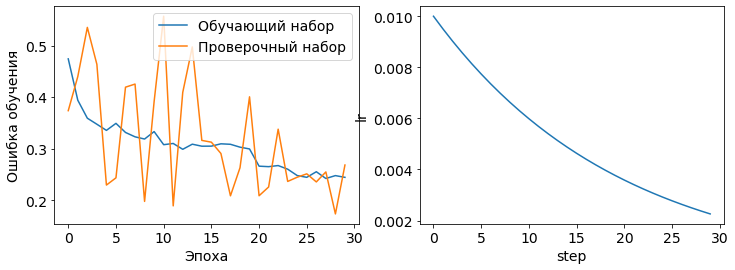

Acc =  0.654627539503386


Epoch 1: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s]


2023-05-19 17:38:08.538327 Epoch 1, Train loss 0.565, Val loss 1.133, Acc_val = 0.46


Epoch 2: 100%|██████████| 125/125 [00:10<00:00, 11.65it/s]


2023-05-19 17:38:21.369978 Epoch 2, Train loss 0.417, Val loss 0.688, Acc_val = 0.51


Epoch 3: 100%|██████████| 125/125 [00:10<00:00, 11.73it/s]


2023-05-19 17:38:34.138647 Epoch 3, Train loss 0.395, Val loss 0.671, Acc_val = 0.60


Epoch 4: 100%|██████████| 125/125 [00:10<00:00, 11.92it/s]


2023-05-19 17:38:46.538595 Epoch 4, Train loss 0.370, Val loss 0.626, Acc_val = 0.54


Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 11.37it/s]


2023-05-19 17:38:59.419924 Epoch 5, Train loss 0.359, Val loss 0.624, Acc_val = 0.53


Epoch 6: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s]


2023-05-19 17:39:11.712321 Epoch 6, Train loss 0.342, Val loss 0.870, Acc_val = 0.50


Epoch 7: 100%|██████████| 125/125 [00:10<00:00, 11.83it/s]


2023-05-19 17:39:24.153440 Epoch 7, Train loss 0.352, Val loss 0.795, Acc_val = 0.45


Epoch 8: 100%|██████████| 125/125 [00:10<00:00, 11.92it/s]


2023-05-19 17:39:36.630923 Epoch 8, Train loss 0.333, Val loss 0.708, Acc_val = 0.45


Epoch 9: 100%|██████████| 125/125 [00:10<00:00, 11.60it/s]


2023-05-19 17:39:49.320223 Epoch 9, Train loss 0.328, Val loss 0.535, Acc_val = 0.66


Epoch 10: 100%|██████████| 125/125 [00:11<00:00, 11.36it/s]


2023-05-19 17:40:02.505907 Epoch 10, Train loss 0.323, Val loss 0.698, Acc_val = 0.49


Epoch 11: 100%|██████████| 125/125 [00:11<00:00, 10.91it/s]


2023-05-19 17:40:16.250869 Epoch 11, Train loss 0.298, Val loss 0.813, Acc_val = 0.47


Epoch 12: 100%|██████████| 125/125 [00:10<00:00, 11.73it/s]


2023-05-19 17:40:29.193950 Epoch 12, Train loss 0.306, Val loss 0.794, Acc_val = 0.46


Epoch 13: 100%|██████████| 125/125 [00:12<00:00, 10.10it/s]


2023-05-19 17:40:44.017736 Epoch 13, Train loss 0.293, Val loss 0.664, Acc_val = 0.60


Epoch 14: 100%|██████████| 125/125 [00:11<00:00, 11.22it/s]


2023-05-19 17:40:57.281400 Epoch 14, Train loss 0.285, Val loss 0.977, Acc_val = 0.57


Epoch 15: 100%|██████████| 125/125 [00:11<00:00, 11.36it/s]


2023-05-19 17:41:10.233074 Epoch 15, Train loss 0.275, Val loss 0.929, Acc_val = 0.56


Epoch 16: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s]


2023-05-19 17:41:22.660276 Epoch 16, Train loss 0.283, Val loss 1.052, Acc_val = 0.46


Epoch 17: 100%|██████████| 125/125 [00:11<00:00, 10.99it/s]


2023-05-19 17:41:35.982294 Epoch 17, Train loss 0.271, Val loss 0.806, Acc_val = 0.51


Epoch 18: 100%|██████████| 125/125 [00:10<00:00, 11.46it/s]


2023-05-19 17:41:48.835719 Epoch 18, Train loss 0.279, Val loss 0.475, Acc_val = 0.69


Epoch 19: 100%|██████████| 125/125 [00:10<00:00, 11.84it/s]


2023-05-19 17:42:01.880598 Epoch 19, Train loss 0.275, Val loss 0.919, Acc_val = 0.49


Epoch 20: 100%|██████████| 125/125 [00:11<00:00, 11.25it/s]


2023-05-19 17:42:14.975467 Epoch 20, Train loss 0.265, Val loss 0.616, Acc_val = 0.53


Epoch 21: 100%|██████████| 125/125 [00:10<00:00, 11.64it/s]


2023-05-19 17:42:27.712605 Epoch 21, Train loss 0.273, Val loss 0.773, Acc_val = 0.44


Epoch 22: 100%|██████████| 125/125 [00:11<00:00, 11.08it/s]


2023-05-19 17:42:41.095119 Epoch 22, Train loss 0.269, Val loss 0.728, Acc_val = 0.51


Epoch 23: 100%|██████████| 125/125 [00:10<00:00, 11.39it/s]


2023-05-19 17:42:54.231924 Epoch 23, Train loss 0.269, Val loss 0.986, Acc_val = 0.50


Epoch 24: 100%|██████████| 125/125 [00:11<00:00, 10.84it/s]


2023-05-19 17:43:07.938294 Epoch 24, Train loss 0.261, Val loss 1.032, Acc_val = 0.54


Epoch 25: 100%|██████████| 125/125 [00:11<00:00, 10.69it/s]


2023-05-19 17:43:21.819081 Epoch 25, Train loss 0.271, Val loss 0.777, Acc_val = 0.50


Epoch 26: 100%|██████████| 125/125 [00:10<00:00, 11.40it/s]


2023-05-19 17:43:35.351989 Epoch 26, Train loss 0.266, Val loss 0.807, Acc_val = 0.46


Epoch 27: 100%|██████████| 125/125 [00:11<00:00, 10.97it/s]


2023-05-19 17:43:48.978275 Epoch 27, Train loss 0.259, Val loss 0.791, Acc_val = 0.48


Epoch 28: 100%|██████████| 125/125 [00:11<00:00, 10.84it/s]


2023-05-19 17:44:03.329314 Epoch 28, Train loss 0.258, Val loss 0.817, Acc_val = 0.48


Epoch 29: 100%|██████████| 125/125 [00:13<00:00,  9.49it/s]


2023-05-19 17:44:19.374529 Epoch 29, Train loss 0.258, Val loss 0.810, Acc_val = 0.51


Epoch 30: 100%|██████████| 125/125 [00:13<00:00,  9.31it/s]


2023-05-19 17:44:35.643518 Epoch 30, Train loss 0.267, Val loss 0.712, Acc_val = 0.47


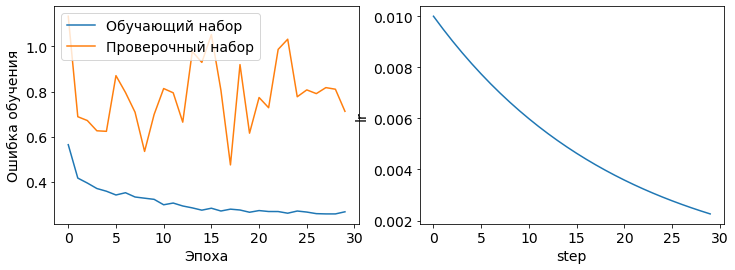

Acc =  0.5218253968253969
Final results
Acc_sk = 0.64
Prec = 0.65
Recall = 0.62
Sens = 0.62
Spec = 0.65


0.6350974930362117

In [130]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # weight_decay is L2 regularization
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=4e-1) # weight_decay is L2 regularization

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=30, k_fold=5)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
